In [1]:
# Check for current GPU in use
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-33a970b0-7eb2-f323-260b-de0ff7303d39)


In [2]:
# You must reinstall this package everytime in my understanding
!pip install tensorflow-wavelets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
from google.colab import runtime
# Mount Drive to be able to access images saved there
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Basic imports
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

#TensorFlow specific imports
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

# Utility imports
import glob
import os
from os.path import join
import time
import gc


In [5]:
# Define paths to images 
TRAIN_PATH_1 = '/content/drive/MyDrive/Stegonography/Proper_Data_All_Train'
files_list_train_1 = glob.glob(join(TRAIN_PATH_1,"*"))

TEST_PATH_1 = '/content/drive/MyDrive/Stegonography/Proper_Data_Test'
files_list_test_1 = glob.glob(join(TEST_PATH_1,"*"))

# Define basic network parameters
SCALE_TO = 64 # Scale of the input images
EPOCHS = 10
BATCH_SIZE = 80
LEARNING_RATE = .0002
BETA = 0.9 # "Weight" difference between the lossess of the cover and secret image. Beta < 1 prioritizes better merged cover (stego image) and Beta > 1 prioritizes better recovered secret 

In [6]:
# Clips batch so that they can be displayed by matplotlib imshow
def clip_batch(imgs,should_clip=True):
    if should_clip:
        imgs= np.clip(imgs,0,1)
    return imgs

In [7]:
def plot_results(full_model, test_covers, test_secrets, ax, index):  

  # Get covers and secret images from the test sets
  covers = test_covers[0: BATCH_SIZE]
  secrets = test_secrets[BATCH_SIZE: 2*BATCH_SIZE] # Perhaps you could use [0: BATCH_SIZE] range here. Seems like a legacy idea 
 
  # Make model predictions
  results = full_model.predict(x = (secrets, covers), batch_size = BATCH_SIZE, verbose=0)

  # Format original images
  cover = covers[index].squeeze()
  secret = secrets[index].squeeze()

  # Show original cover and secret
  ax[0,0].imshow(clip_batch(cover))
  ax[1,0].imshow(clip_batch(secret))
  
  # Format stego images
  recovered_secret = np.array(results[0].squeeze())
  recovered_cover = np.array(results[1].squeeze())
  
  # Show merged cover and recovered secret
  ax[0,1].imshow(clip_batch(recovered_cover[index]))
  ax[1,1].imshow(clip_batch(recovered_secret[index]))


In [10]:
# Hide network that takes both the original cover and secret as inputs and outputs the merged cover (stego image)
def get_hide_net(cover_tensor, secret_tensor):

  # Concat both original images
  scope_name_1 = 'hiding_net'
  concat_input = tf.concat([cover_tensor, secret_tensor],axis=3,name=scope_name_1 + '/' +'images_features_concat')
  
  # Sequential convolutions for each of the different kernel sizes
  scope_name_2 = '3x3_conv_branch'
  conv_3x3 = tf.keras.layers.Conv2D(filters=50,kernel_size=3,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"1",activation=tf.nn.relu) (concat_input)
  conv_3x3 = tf.keras.layers.Conv2D(filters=50,kernel_size=3,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"2",activation=tf.nn.relu) (conv_3x3)
  conv_3x3 = tf.keras.layers.Conv2D(filters=50,kernel_size=3,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"3",activation=tf.nn.relu) (conv_3x3)
  conv_3x3 = tf.keras.layers.Conv2D(filters=50,kernel_size=3,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"4",activation=tf.nn.relu) (conv_3x3)
  
  scope_name_2 = '4x4_conv_branch'
  conv_4x4 = tf.keras.layers.Conv2D(filters=50,kernel_size=4,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"1",activation=tf.nn.relu) (concat_input)
  conv_4x4 = tf.keras.layers.Conv2D(filters=50,kernel_size=4,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"2",activation=tf.nn.relu) (conv_4x4)  
  conv_4x4 = tf.keras.layers.Conv2D(filters=50,kernel_size=4,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"3",activation=tf.nn.relu) (conv_4x4) 
  conv_4x4 = tf.keras.layers.Conv2D(filters=50,kernel_size=4,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"4",activation=tf.nn.relu) (conv_4x4) 

  scope_name_2 = '5x5_conv_branch'
  conv_5x5 = tf.keras.layers.Conv2D(filters=50,kernel_size=5,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"1",activation=tf.nn.relu) (concat_input)
  conv_5x5 = tf.keras.layers.Conv2D(filters=50,kernel_size=5,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"2",activation=tf.nn.relu) (conv_5x5) 
  conv_5x5 = tf.keras.layers.Conv2D(filters=50,kernel_size=5,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"3",activation=tf.nn.relu) (conv_5x5)
  conv_5x5 = tf.keras.layers.Conv2D(filters=50,kernel_size=5,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"4",activation=tf.nn.relu) (conv_5x5)

  # Concatenation and final convolutions so that output_hide has the same dimensions as the both the cover_tensor and secret_tensor
  concat_2 = tf.concat([conv_3x3,conv_4x4,conv_5x5],axis=3,name=scope_name_1 + '/' +'concat_1')
  conv_5x5 = tf.keras.layers.Conv2D(filters=50,kernel_size=5,padding='same',name=scope_name_1 + '/' +"final_5x5",activation=tf.nn.relu) (concat_2)
  conv_4x4 = tf.keras.layers.Conv2D(filters=50,kernel_size=4,padding='same',name=scope_name_1 + '/' +"final_4x4",activation=tf.nn.relu) (concat_2)
  conv_3x3 = tf.keras.layers.Conv2D(filters=50,kernel_size=3,padding='same',name=scope_name_1 + '/' +"final_3x3",activation=tf.nn.relu) (concat_2)

  concat_final_2 = tf.concat([conv_5x5,conv_4x4,conv_3x3],axis=3,name=scope_name_1 + '/' +'concat_final')
  output_hide = tf.keras.layers.Conv2D(filters=3,kernel_size=1,padding='same',name=scope_name_1 + '/' +'output') (concat_final_2)

  # Build the graph model based on the network defined above
  hide_net = keras.Model(
  inputs=[cover_tensor, secret_tensor],
  outputs=[output_hide],
  )
  
  return hide_net

# Normal noise layer that may be used but which may make the results much worse! (To solve this you must analyze how big of a stddev you should use)
def get_noise_layer(output_hide, std = 0.1):
  output_noise = output_hide + tf.random.normal(shape=tf.shape(output_hide), mean=0.0, stddev=std, dtype=tf.float64)
  
  noise_layer = keras.Model(
  inputs=[output_hide],
  outputs=[output_noise],
  )
  
  return noise_layer

# Reveal network that takes the stego image outputed by the hiding net as input and outputs the recovered secret image 
def get_reveal_net(output_noise):
    
  # Very similar topology as on the hiding network
  scope_name_1 = 'reveal_net'
  scope_name_2 = '3x3_conv_branch'
  conv_3x3 = tf.keras.layers.Conv2D(filters=50,kernel_size=3,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"1",activation=tf.nn.relu) (output_noise)
  conv_3x3 = tf.keras.layers.Conv2D(filters=50,kernel_size=3,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"2",activation=tf.nn.relu) (conv_3x3)
  conv_3x3 = tf.keras.layers.Conv2D(filters=50,kernel_size=3,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"3",activation=tf.nn.relu) (conv_3x3)
  conv_3x3 = tf.keras.layers.Conv2D(filters=50,kernel_size=3,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"4",activation=tf.nn.relu) (conv_3x3)

  scope_name_2 = '4x4_conv_branch'
  conv_4x4 = tf.keras.layers.Conv2D(filters=50,kernel_size=4,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"1",activation=tf.nn.relu) (output_noise)
  conv_4x4 = tf.keras.layers.Conv2D(filters=50,kernel_size=4,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"2",activation=tf.nn.relu) (conv_4x4)       
  conv_4x4 = tf.keras.layers.Conv2D(filters=50,kernel_size=4,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"3",activation=tf.nn.relu) (conv_4x4)     
  conv_4x4 = tf.keras.layers.Conv2D(filters=50,kernel_size=4,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"4",activation=tf.nn.relu) (conv_4x4)     


  scope_name_2 = '5x5_conv_branch'
  conv_5x5 = tf.keras.layers.Conv2D(filters=50,kernel_size=5,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"1",activation=tf.nn.relu) (output_noise)
  conv_5x5 = tf.keras.layers.Conv2D(filters=50,kernel_size=5,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"2",activation=tf.nn.relu) (conv_5x5)    
  conv_5x5 = tf.keras.layers.Conv2D(filters=50,kernel_size=5,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"3",activation=tf.nn.relu) (conv_5x5)  
  conv_5x5 = tf.keras.layers.Conv2D(filters=50,kernel_size=5,padding='same',name=scope_name_1 + '/' + scope_name_2 + '/' +"4",activation=tf.nn.relu) (conv_5x5)  

  # Concatenation and final convolutions so that output_hide has the same dimensions as the both the cover_tensor and secret_tensor
  concat_3 = tf.concat([conv_3x3,conv_4x4,conv_5x5],axis=3,name=scope_name_1 + '/' +'concat_1')

  conv_5x5 = tf.keras.layers.Conv2D(filters=50,kernel_size=5,padding='same',name=scope_name_1 + '/' +"final_5x5",activation=tf.nn.relu) (concat_3)
  conv_4x4 = tf.keras.layers.Conv2D(filters=50,kernel_size=4,padding='same',name=scope_name_1 + '/' +"final_4x4",activation=tf.nn.relu) (concat_3)
  conv_3x3 = tf.keras.layers.Conv2D(filters=50,kernel_size=3,padding='same',name=scope_name_1 + '/' +"final_3x3",activation=tf.nn.relu) (concat_3)

  concat_final_3 = tf.concat([conv_5x5,conv_4x4,conv_3x3],axis=3,name=scope_name_1 + '/' +'concat_final')

  output_reveal = tf.keras.layers.Conv2D(filters=3,kernel_size=1,padding='same',name=scope_name_1 + '/' +'output') (concat_final_3)

  # Build the graph model based on the network defined above
  reveal_net = keras.Model(
  inputs=[output_noise],
  outputs=[output_reveal],
  )

  return reveal_net



In [11]:
# Define a custom loss for the model based on the domain-specific metrics PSNR and SSIM using their TF implementations (this is necessary)
def get_custom_loss(y_true, y_pred):
  gain = 0
  
  # This "40" is a constant that weights how much influence the PSNR will have in comparison to the SSIM. Larger values leads to greater SSIM importance and lower values leads
  # to greater PSNR importance. 40 is the "recommended value"
  gain += tf.image.psnr(y_true, y_pred, 1.)/40 
  gain += tf.image.ssim(y_true, y_pred, 1.)

  return -1*gain

In [12]:
def make_full_network(scale, batch, beta):
    # Get "placeholder" inputs for the networks 
    cover_input = tf.keras.layers.Input(shape = (int(scale), int(scale), 3), dtype='float64', batch_size = batch)
    secret_input = tf.keras.layers.Input(shape = (int(scale), int(scale), 3), dtype='float64', batch_size = batch)
    
    # Get network using placeholder inputs
    hide_net = get_hide_net(cover_input, secret_input)
    # Apply the network to the placeholder inputs
    output_hide = hide_net([cover_input, secret_input])
    output_hide = tf.cast(output_hide, dtype = 'float64', name=None)

    # Using the output to create a placeholder input for the next network
    output_hide_as_input = tf.keras.layers.Input(shape = output_hide.shape[1:], dtype='float64', batch_size = batch)
    
    # Use the following lines if you want to use the noise layer
    # output_hide_as_input = tf.keras.layers.Input(shape = output_hide.shape[1:], dtype='float64', batch_size = batch)
    # noise_layer = get_noise_layer(output_hide_as_input)
    # output_noise = noise_layer(output_hide)
    # output_noise_as_input = tf.keras.layers.Input(shape = output_noise.shape[1:], dtype='float64', batch_size = batch)
    # reveal_net = get_reveal_net(output_noise_as_input)
    # output_reveal = reveal_net(output_noise)

    # Use the following lines if you DO NOT want to use the noise layer. Same idea as for the hide network
    reveal_net = get_reveal_net(output_hide_as_input)
    output_reveal = reveal_net(output_hide)
    output_reveal = tf.cast(output_reveal, dtype = 'float64', name=None)

    # Obataining the models by sections
    hide_model = keras.Model(inputs=[secret_input, cover_input], outputs=[output_hide])
    reveal_model = keras.Model(inputs=[output_hide], outputs=[output_reveal])
    full_model =  keras.Model(inputs=[secret_input, cover_input], outputs=[output_reveal, output_hide])
    
    # Creating metrics elements for evaluation during training. THIS IS NOT THE LOSS (there must be a more efficient way to do this but I could not find out)
    loss_psnr_secret = tf.image.psnr(secret_input, output_reveal, 1., name=None)
    loss_psnr_cover = tf.image.psnr(cover_input, output_hide, 1., name=None)
    loss_ssim_secret = tf.image.ssim(secret_input, output_reveal, 1.)
    loss_ssim_cover = tf.image.ssim(cover_input, output_hide, 1.)
    
    
    full_model.add_metric(loss_psnr_secret/40, name = 'psnr_secret') # The constant here must be the same used in the get_custom_loss function for the results reported during training to be accurate.
    full_model.add_metric(loss_psnr_cover/40, name = 'psnr_cover') # The constant here must be the same used in the get_custom_loss function for the results reported during training to be accurate.
    full_model.add_metric(1*loss_ssim_secret, name = 'ssim_secret')
    full_model.add_metric(1*loss_ssim_cover, name = 'ssim_cover')

    # Compiling full model using the parameters defined above and the custom loss implemented. 
    full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss = [get_custom_loss, get_custom_loss], loss_weights = [1,beta]) #[tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredError()]
    
    return hide_model, reveal_model, full_model

In [13]:
# Load test images that will be used to generate sample results after each epoch
for file in files_list_test_1:
  print(file)
  images = np.load(file)
  files = images.files
  images = images[files[0]]

  images_test = images[:-11]
  covers_test = images[:int(len(images_test)/2)]
  secrets_test = images[int(len(images_test)/2):]

/content/drive/MyDrive/Stegonography/Proper_Data_Test/train_data_batch_10_split_9.npz


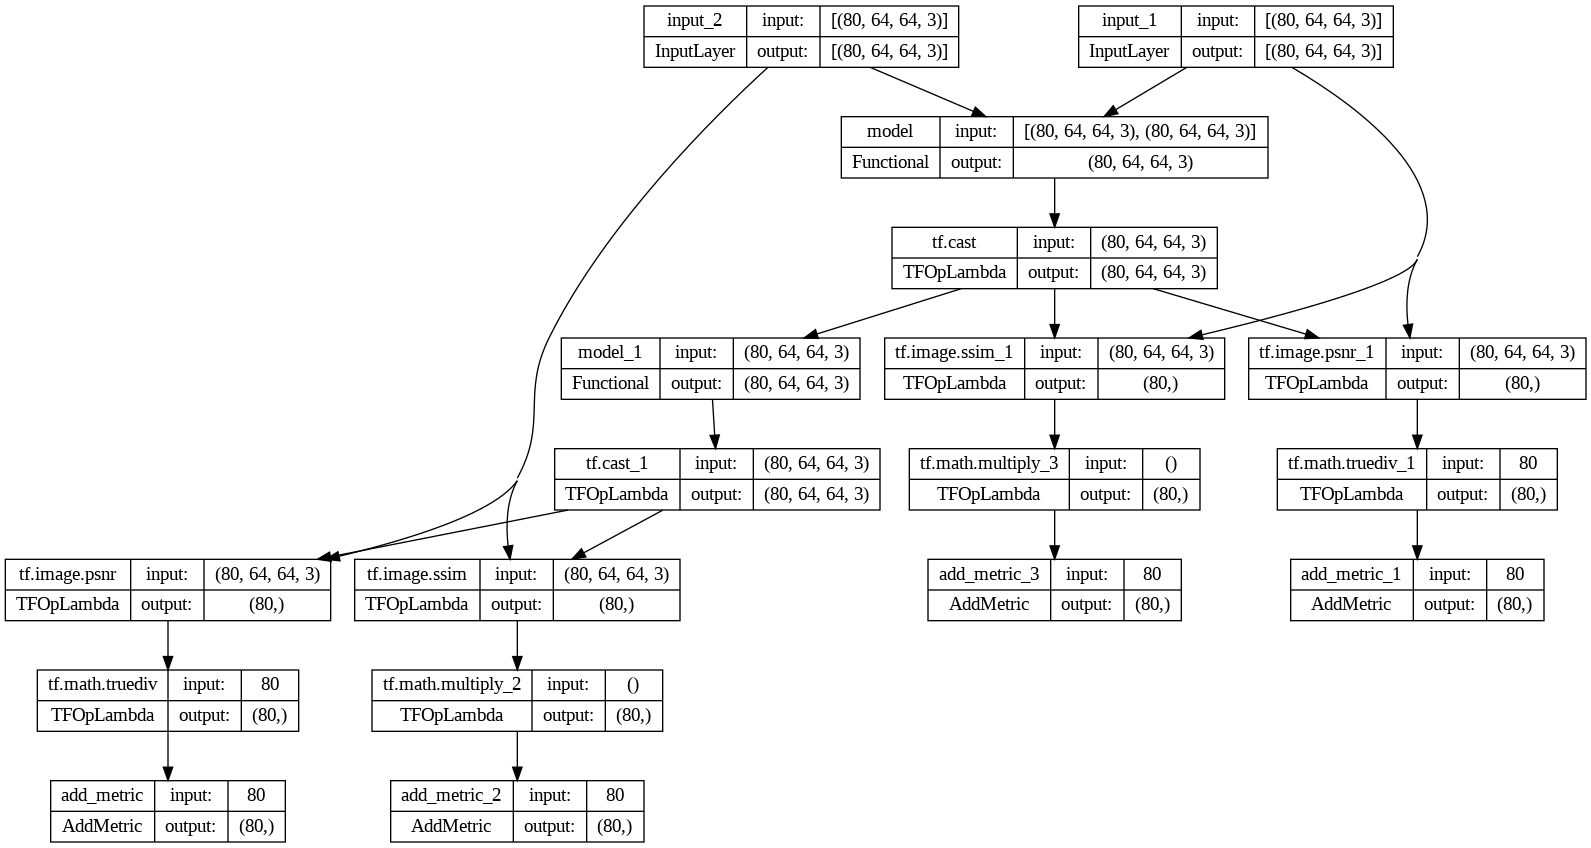

In [14]:
# Create model and plot graph
hide_net, reveal_net, full_model = make_full_network(SCALE_TO, BATCH_SIZE, BETA)

keras.utils.plot_model(full_model, "full_model_functional.png", show_shapes=True)

In [15]:
start_time = time.time()

# We have to build a "custom training loop" here because we had to separate the input data into multiple batches. For each epoch in the number of epochs, loop through all the data batches.
for epoch in range(EPOCHS):
    print('________________ Epoch ' + str(epoch) + ' ________________\n\n\n')
    
    for file in files_list_train_1:
        
        #Load images and separate them into cover and secret images
        images = np.load(file)
        files = images.files
        images = images[files[0]]

        images = images[:-11] # We remove the last 11 elements because we need len(images/2) to be a multiple of 10 for the validation_split we are using in the fit function. If it is not a multiple it crashes.
        covers = images[:int(len(images)/2)]
        secrets = images[int(len(images)/2):]
        
        # Does garbage collection because otherwise there is creeping RAM usage
        gc.collect()
        tf.keras.backend.clear_session()

        # Fit model to current data batch
        history = full_model.fit(x = (secrets, covers), y = (secrets, covers), batch_size =  BATCH_SIZE, epochs = 1, verbose = 1, shuffle = True, validation_split = 0.1)

        
      
    # Saves the current model after each epoch so that we can select the best model after the number of epochs used and avoid overfitting. This would be better implemented with a callback but because of the "custom training loop" we have to do it this way
    saving_path =  '/content/drive/MyDrive/Nicolas Vana Deep Stego/Saved Models/Gain_with_PSNR_and_SSIM_plain/Beta 0.90 Factor 40 Epochs 10/'
    full_model.save(saving_path + 'epoch=' + str(epoch))
    
    # Generates sample images for us to analyze after each epoch.
    os.mkdir(saving_path + 'images_epoch=' + str(epoch))
    for index in range(5):
      fig, ax = plt.subplots(2,2, figsize = (10,10))
      plot_results(full_model, covers_test, secrets_test, ax, index)
      fig.savefig(saving_path + 'images_epoch=' + str(epoch) + '/example ' + str(index) + '.png')

finish_time = time.time()
print(finish_time - start_time)


________________ Epoch 0 ________________



72/72 [==============================] - 67s 918ms/step - loss: -2.8035 - tf.cast_1_loss: -1.3666 - tf.cast_loss: -1.5965 - psnr_secret: 0.5222 - psnr_cover: 0.6757 - ssim_secret: 0.8444 - ssim_cover: 0.9208 - val_loss: -2.8747 - val_tf.cast_1_loss: -1.4116 - val_tf.cast_loss: -1.6256 - val_psnr_secret: 0.5524 - val_psnr_cover: 0.6954 - val_ssim_secret: 0.8592 - val_ssim_cover: 0.9302


KeyboardInterrupt: ignored

In [ ]:
# This cell is used to delete the Colab runtime after finishing training. This is done to avoid idle time and "compute units" usage after finishing training. Always queue it after the previous cell is running.
runtime.unassign()